> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

# Training a model

In [1]:
import os

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [2]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['background', 'building'], 
    colors=['lightgray', 'darkred'],
    null_class='background')

To keep things simple, we use one scene for training and one for validation. In a real workflow, we would normally use many more scenes.

In [3]:
train_image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif'
train_label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson'

In [4]:
val_image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/images/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif'
val_label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/labels/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson'

In [5]:
import albumentations as A

from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset,
    SemanticSegmentationVisualizer)

viz = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

In [6]:
data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        A.RGBShift(),
        A.ToGray(),
        A.ToSepia(),
        A.RandomBrightness(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
])

train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=train_image_uri,
    label_vector_uri=train_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size_lims=(150, 200),
    out_size=256,
    max_windows=400,
    transform=data_augmentation_transform)

len(train_ds)

2023-07-20 18:29:23:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif.
2023-07-20 18:29:23:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson.


400

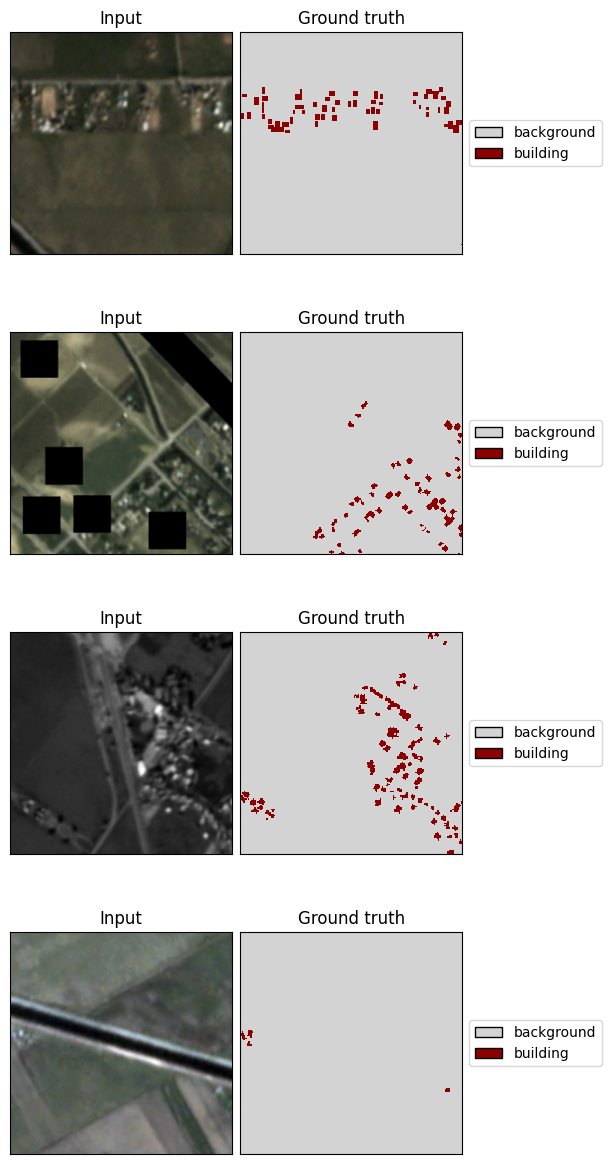

In [10]:
x, y = viz.get_batch(train_ds, 4)
viz.plot_batch(x, y, show=True)

In [11]:
val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=val_image_uri,
    label_vector_uri=val_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size=200,
    stride=100,
    transform=A.Resize(256, 256))
len(val_ds)

2023-07-20 18:29:58:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/images/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif.
2023-07-20 18:29:58:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/labels/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson.


100

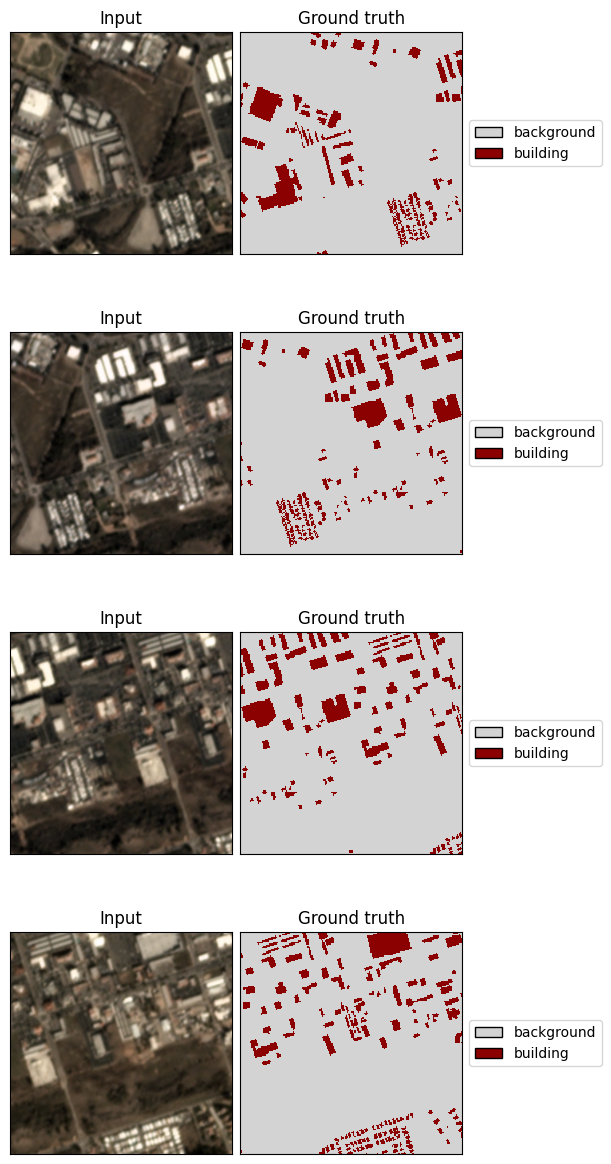

In [12]:
x, y = viz.get_batch(val_ds, 4)
viz.plot_batch(x, y, show=True)

## Define model

Use a [light-weight panoptic FPN model](https://github.com/AdeelH/pytorch-fpn) with a ResNet-18 backbone.

In [13]:
import torch

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(256, 256),
    pretrained=True)

Downloading: "https://github.com/AdeelH/pytorch-fpn/zipball/0.3" to /root/.cache/torch/hub/0.3.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:07<00:00, 6.41MB/s]


## Configure the training

In [14]:
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig

data_cfg = SemanticSegmentationGeoDataConfig(
    class_names=class_config.names,
    class_colors=class_config.colors,
    num_workers=0, # increase to use multi-processing
)

In [15]:
from rastervision.pytorch_learner import SolverConfig

solver_cfg = SolverConfig(
    batch_sz=8,
    lr=3e-2,
    class_loss_weights=[1., 10.]
)

In [16]:
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig

learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

In [18]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir='./train-demo/',
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
)

In [19]:
learner.log_data_stats()

2023-07-20 18:32:03:rastervision.pytorch_learner.learner: INFO - train_ds: 400 items
2023-07-20 18:32:03:rastervision.pytorch_learner.learner: INFO - valid_ds: 100 items


## Run `Tensorboard` for monitoring

In [13]:
%load_ext tensorboard

This will start an instance of tensorboard and embed it in the output of the cell:

In [ ]:
%tensorboard --bind_all --logdir "./train-demo/tb-logs" --reload_interval 10 

![A screenshot of the Tensorboard dashboard.](../../img/tensorboard.png "A screenshot of the Tensorboard dashboard.")


In [20]:
learner.train(epochs=3)

2023-07-20 18:32:10:rastervision.pytorch_learner.learner: INFO - epoch: 0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2023-07-20 18:32:24:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 0,
 'train_loss': 0.27799662947654724,
 'train_time': '0:00:10.766141',
 'val_loss': 0.8478022217750549,
 'avg_precision': 0.914511501789093,
 'avg_recall': 0.9329541325569153,
 'avg_f1': 0.9236407279968262,
 'background_precision': 0.9493319988250732,
 'background_recall': 0.9810829758644104,
 'background_f1': 0.9649463891983032,
 'building_precision': 0.3630911707878113,
 'building_recall': 0.17078089714050293,
 'building_f1': 0.23229923844337463,
 'valid_time': '0:00:03.016010'}
2023-07-20 18:32:24:rastervision.pytorch_learner.learner: INFO - epoch: 1


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2023-07-20 18:32:33:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 1,
 'train_loss': 0.267794132232666,
 'train_time': '0:00:06.380853',
 'val_loss': 0.553295910358429,
 'avg_precision': 0.9242435693740845,
 'avg_recall': 0.912998378276825,
 'avg_f1': 0.9185865521430969,
 'background_precision': 0.962364912033081,
 'background_recall': 0.9444385170936584,
 'background_f1': 0.9533174633979797,
 'building_precision': 0.3205510973930359,
 'building_recall': 0.41510921716690063,
 'building_f1': 0.3617531657218933,
 'valid_time': '0:00:03.077122'}
2023-07-20 18:32:34:rastervision.pytorch_learner.learner: INFO - epoch: 2


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2023-07-20 18:32:43:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 2,
 'train_loss': 0.24602511525154114,
 'train_time': '0:00:06.327937',
 'val_loss': 0.5151494741439819,
 'avg_precision': 0.9173383712768555,
 'avg_recall': 0.7924740314483643,
 'avg_f1': 0.8503469228744507,
 'background_precision': 0.9656632542610168,
 'background_recall': 0.8081037402153015,
 'background_f1': 0.8798856735229492,
 'building_precision': 0.15206032991409302,
 'building_recall': 0.5449610948562622,
 'building_f1': 0.23777452111244202,
 'valid_time': '0:00:03.060584'}


## Train some more

In [21]:
learner.train(epochs=1)

2023-07-20 18:32:46:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 3
2023-07-20 18:32:46:rastervision.pytorch_learner.learner: INFO - epoch: 3


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2023-07-20 18:32:56:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 3,
 'train_loss': 0.23821613192558289,
 'train_time': '0:00:06.718812',
 'val_loss': 0.44583913683891296,
 'avg_precision': 0.9300351142883301,
 'avg_recall': 0.7758152484893799,
 'avg_f1': 0.8459539413452148,
 'background_precision': 0.9779573082923889,
 'background_recall': 0.7792219519615173,
 'background_f1': 0.867351233959198,
 'building_precision': 0.1711343377828598,
 'building_recall': 0.7218664288520813,
 'building_f1': 0.2766764163970947,
 'valid_time': '0:00:03.036754'}


2022-10-21 14:00:43:rastervision.pytorch_learner.learner: INFO - Plotting predictions...


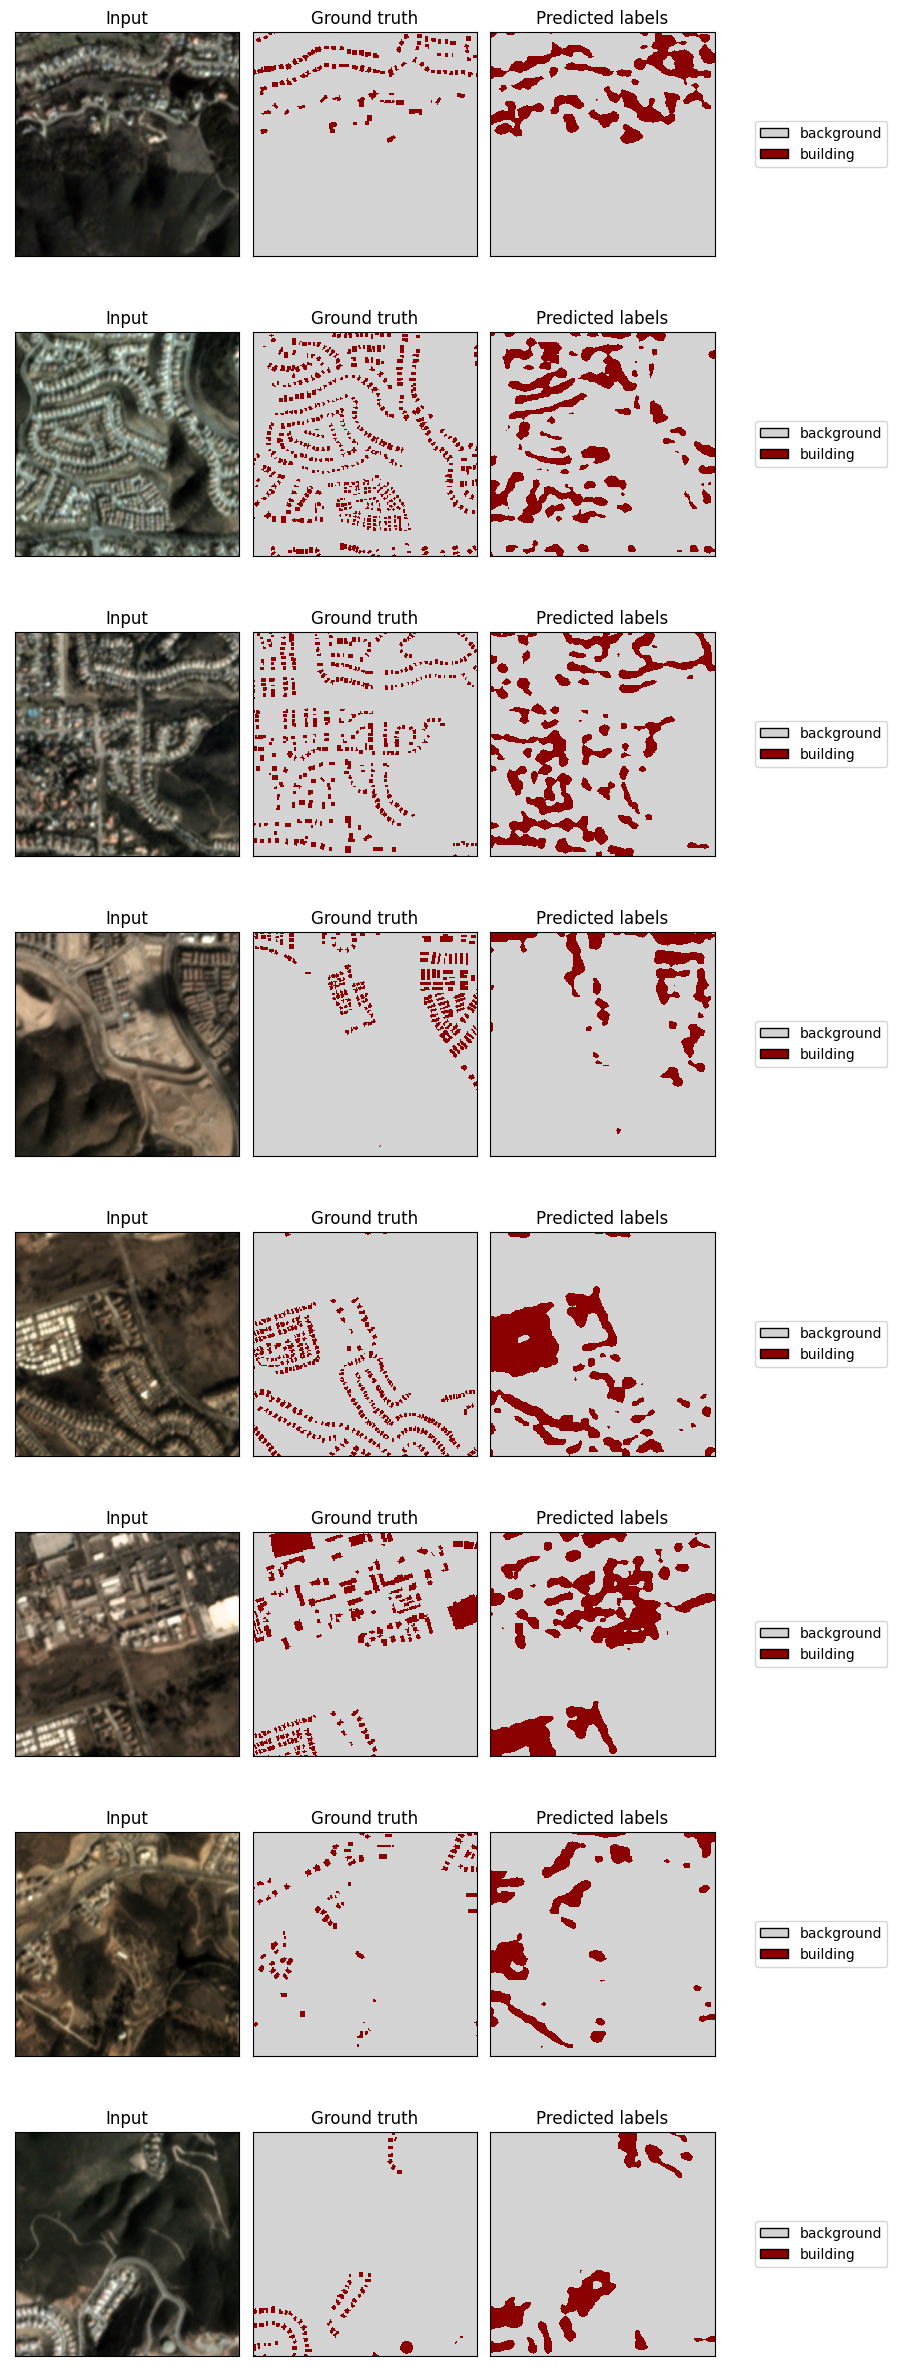

<Figure size 640x480 with 0 Axes>

In [19]:
learner.plot_predictions(split='valid', show=True)

Note the warning about `ModelConfig`. This is relevant when loading from from the bundle as we will see [below](#Using-model-bundles).

In [23]:
learner.save_model_bundle()

2023-07-20 18:33:28:rastervision.pytorch_learner.learner: WARNING - Model was not configured via ModelConfig, and therefore, will not be reconstructable form the model-bundle. You will need to initialize the model yourself and pass it to from_model_bundle().
2023-07-20 18:33:28:rastervision.pytorch_learner.learner: INFO - Creating bundle.
2023-07-20 18:33:29:rastervision.pytorch_learner.learner: INFO - Exporting to model to ONNX.
2023-07-20 18:33:29:rastervision.pytorch_learner.learner: INFO - Saving bundle to ./train-demo/model-bundle.zip.


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## Examine learner output

The trained model weights are saved at `./train-demo/last-model.pth` as well as inside the model-bundle.

In [24]:
!tree "./train-demo/"

./train-demo/
├── last-model.pth
├── learner-config.json
├── log.csv
├── model-bundle.zip
├── tb-logs
│   └── events.out.tfevents.1689877923.c4b8332998d8.7704.0
└── valid_preds.png

1 directory, 6 files


## Using model-bundles

We can use the model-bundle to re-construct our `Learner` and then use it to make predictions.

In [25]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(
    model_bundle_uri='./train-demo/model-bundle.zip',
    output_dir='./train-demo/',
    model=model,
)

2023-07-20 18:33:45:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle ./train-demo/model-bundle.zip.
2023-07-20 18:33:45:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmp_1eti8dr/model-bundle
2023-07-20 18:33:46:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmp_1eti8dr/model-bundle/model.pth


For next steps, see the ["Prediction and Evaluation" tutorial](./pred_and_eval_ss.ipynb).

We can also re-construct the `Learner` in order to continue training, perhaps on a different dataset. To do this, we pass in `train_ds` and `val_ds` and set `training=True`

In [26]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(
    model_bundle_uri='./train-demo/model-bundle.zip',
    output_dir='./train-demo/',
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
    training=True,
)

2023-07-20 18:33:50:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle ./train-demo/model-bundle.zip.
2023-07-20 18:33:50:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmpwpo39yb3/model-bundle
2023-07-20 18:33:51:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmpwpo39yb3/model-bundle/model.pth
2023-07-20 18:33:51:rastervision.pytorch_learner.learner: INFO - Loading checkpoint from ./train-demo/last-model.pth


Continue training:

In [27]:
learner.train(epochs=1)

2023-07-20 18:33:55:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 4
2023-07-20 18:33:55:rastervision.pytorch_learner.learner: INFO - epoch: 4


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2023-07-20 18:34:04:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 4,
 'train_loss': 0.31361809372901917,
 'train_time': '0:00:06.604501',
 'val_loss': 0.640304684638977,
 'avg_precision': 0.9447709918022156,
 'avg_recall': 0.4672073423862457,
 'avg_f1': 0.6252276301383972,
 'background_precision': 0.9981610178947449,
 'background_recall': 0.43436339497566223,
 'background_f1': 0.6053154468536377,
 'building_precision': 0.09928074479103088,
 'building_recall': 0.9873272180557251,
 'building_f1': 0.1804194152355194,
 'valid_time': '0:00:03.196762'}
